In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

In [2]:
import talib
from ta import add_all_ta_features

In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
                             median_absolute_error, r2_score,accuracy_score,
                             roc_auc_score,classification_report,confusion_matrix,ConfusionMatrixDisplay)
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

### Read full database

In [5]:
DATA_PATH = r'../data/'
FILE_NAME = '20220313_034756_111.pkl'
FULL_PATH = Path(DATA_PATH,FILE_NAME)

In [35]:
%time
raw = pd.read_pickle(FULL_PATH)
raw.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


(5675397, 14)

In [37]:
raw.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                                object
high                                object
low                                 object
close                               object
volume                              object
numTrades                            int64
quoteAssetVolume                    object
takerBuyBaseAssetVolume             object
takerBuyQuoteAssetVolume            object
dtype: object

In [38]:
raw.symbol.value_counts()

BTCUSDT     87964
ETHUSDT     80325
BCHUSDT     78208
XRPUSDT     76486
EOSUSDT     76292
            ...  
BAKEUSDT    28582
BTTUSDT     28339
GTCUSDT     26390
TLMUSDT     23032
KEEPUSDT    22843
Name: symbol, Length: 111, dtype: int64

### Prepare and subset dataset

In [265]:
df = raw.query('symbol=="ETHUSDT"')
assert df.isnull().sum().sum() == 0
df.shape

(80325, 14)

In [266]:
# create datatypes dictionary
datatypes = {k:'float32' if k!='numTrades' else 'int32' for k in df.loc[:,'open':].columns}
# assign datatypes
df = df.astype(datatypes)
assert df.isnull().sum().sum() == 0
df.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                               float32
high                               float32
low                                float32
close                              float32
volume                             float32
numTrades                            int32
quoteAssetVolume                   float32
takerBuyBaseAssetVolume            float32
takerBuyQuoteAssetVolume           float32
dtype: object

In [268]:
df.to_pickle('../data/eth.pkl')

### Read dataset from disk

In [4]:
raw = pd.read_pickle('../data/eth.pkl')

### Group on desired frequency

In [5]:
df = \
    raw.groupby(pd.Grouper(key="openTime", freq="1H"))\
    .agg(
        cnt=pd.NamedAgg(column="symbol", aggfunc="size"),
        opentime=pd.NamedAgg(column="openTime", aggfunc="min"),
        closetime=pd.NamedAgg(column="openTime", aggfunc="min"),
        open=pd.NamedAgg(column="open", aggfunc="first"),
        high=pd.NamedAgg(column="high", aggfunc="max"),
        low=pd.NamedAgg(column="low", aggfunc="min"),
        close=pd.NamedAgg(column="close", aggfunc="last"),
        volume=pd.NamedAgg(column="volume", aggfunc="sum"),
        numtrade=pd.NamedAgg(column="numTrades", aggfunc="sum"),
    )\
    .query('cnt >= 4')\
    .drop('cnt',axis=1)\
    .assign(closetime = lambda x : x.closetime + pd.Timedelta(minutes=59))\
    .reset_index(drop=True)

# alternative way to resample and regroup data
# df = raw.resample('30min',on='opentime').agg({'close':'last','high':'max'}).tail(10)
df.tail()

,opentime,closetime,open,high,low,close,volume,numtrade
20076,2022-03-12 20:00:00,2022-03-12 20:59:00,2576.760010,2591.659912,2573.870117,2586.800049,25150.187500,35923
20077,2022-03-12 21:00:00,2022-03-12 21:59:00,2586.800049,2591.719971,2583.060059,2585.649902,13017.638672,24267
20078,2022-03-12 22:00:00,2022-03-12 22:59:00,2585.649902,2591.379883,2583.260010,2585.830078,10603.583008,26367
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,49081
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,50466


### Inspect Time Series

count                  20081
mean     2021-01-18 16:00:00
min      2019-11-27 08:00:00
25%      2020-06-23 12:00:00
50%      2021-01-18 16:00:00
75%      2021-08-15 20:00:00
max      2022-03-13 00:00:00
Name: opentime, dtype: object
AxesSubplot(0.125,0.125;0.775x0.755)


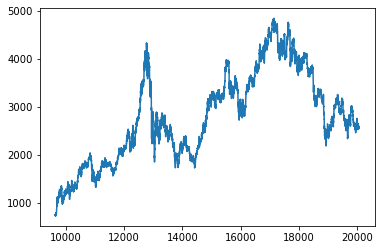

In [6]:
print(df.opentime.describe(datetime_is_numeric=True))
# print(df.close.plot())
print(df.query('opentime >= 2021').close.plot())

In [7]:
df = df.query('opentime >= 2021').copy()
df.shape

(10465, 8)

### Decompose Time Series

In [8]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# # from statsmodels.tsa.seasonal import MSTL
# print(plot_acf(df.close))
# print(plot_pacf(df.close))
# # stl_kwargs = {"seasonal_deg": 0} 
# # model = MSTL(df.close, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
# # res = model.fit()
# # res.plot()

### Create Features to Avoid Leakage
> __close -> fx_close = close.shift(1)__

In [9]:
options_antileakage_feats = ['open','high','low','close','volume']
for ff in options_antileakage_feats:
    df[f'fx_{ff}'] = df[ff].shift(1)

In [10]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume'],
      dtype='object')

### Create Lag Features

In [11]:
options_lags_feats = ['close','volume']
options_lags = [1,2,3,24,48]
for ff in options_lags_feats:
    for ll in options_lags:
        df[f'fx_{ff}_lag_{str(ll).zfill(3)}'] = df[ff].shift(ll)

In [12]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048'],
      dtype='object')

In [13]:
df.shape

(10465, 23)

### Create Diff Features

In [14]:
options_diffs_feats = ['fx_close','fx_volume']
options_diffs = [1,2,3,24,48]
for ff in options_diffs_feats:
    for ll in options_diffs:
        df[f'{ff}_diff_{str(ll).zfill(3)}'] = df[ff].diff(ll)

In [15]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048'],
      dtype='object')

In [16]:
df.shape

(10465, 33)

### Create Rolling Features

In [17]:
options_wndf_feats = ['fx_close','fx_volume']
options_wndf = [24,24*7]
for ff in options_wndf_feats:
    for ll in options_wndf:
        df[f'{ff}_min_{str(ll).zfill(3)}'] = df[ff].rolling(ll).min()
        df[f'{ff}_max_{str(ll).zfill(3)}'] = df[ff].rolling(ll).max()
        df[f'{ff}_std_{str(ll).zfill(3)}'] = df[ff].rolling(ll).std()

In [18]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048', 'fx_close_min_024',
       'fx_close_max_024', 'fx_close_std_024', 'fx_close_min_168',
       'fx_close_max_168', 'fx_close_std_168', 'fx_volume_min_024',
       'fx_volume_max_024', 'fx_volume_std_024', 'fx_volume_min_168',
       'fx_volume_max_168', 'fx_volume_std_168'],
      dtype='object')

In [19]:
df.shape

(10465, 45)

### Create TA Features - Manually

In [20]:
# df = \
#     df.assign(
#         fx_sma_fast = lambda x : talib.SMA(x.close.shift(1),8),
#         fx_sma_slow = lambda x : x.close.shift(1).rolling(24).mean(),
#         fx_ema_fast = lambda x : talib.EMA(x.close.shift(1),8),
#         fx_ema_slow = lambda x : talib.EMA(x.close.shift(1),24),
#         fx_atr = lambda x : talib.ATR(x.high.shift(1),x.low.shift(1),x.close.shift(1),12),
#         fx_adx = lambda x : talib.ADX(x.high.shift(1),x.low.shift(1),x.close.shift(1),20),
#         fx_rsi = lambda x : talib.RSI(x.close.shift(1),12),
#         fx_bb_upper = lambda x : talib.BBANDS(x.close.shift(1))[0],
#         fx_bb_middle = lambda x : talib.BBANDS(x.close.shift(1))[1],
#         fx_bb_lower = lambda x : talib.BBANDS(x.close.shift(1))[2],
#     ).assign(
#         fx_sma_fast_slow_frc = lambda x : (x.fx_sma_fast/x.fx_sma_slow)
#     )
#
# df.tail(2)
# df.columns
# df.shape

### Create TA Features - Automatically

In [21]:
df = add_all_ta_features(
    df, 
    open='fx_open', 
    high='fx_high', 
    low='fx_low', 
    close='fx_close', 
    volume='fx_volume', 
    fillna=True)
df.columns

/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'momentum_wr', 'momentum_ao', 'momentum_kama', 'momentum_roc',
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr',
       'others_dlr', 'others_cr'],
      dtype='object', length=128)

In [22]:
df = \
    df.assign(
        sma_fast_slow_frc = lambda x : (x.trend_sma_fast/x.trend_sma_slow),
        ema_fast_slow_frc = lambda x : (x.trend_ema_fast/x.trend_ema_slow)
    )

### Enable Pattern Recognition Features

In [23]:
talib.get_function_groups().keys()
# pattern_recognition_functions = [x for x in dir(talib) if x.startswith('CDL')]
pattern_recognition_functions = talib.get_function_groups().get('Pattern Recognition')
# pattern_recognition_functions[1::10]
# create pattern recognition features
pattern_features = {
    f'pt_{x.lower()}': getattr(talib,x)(df['fx_open'],df['fx_high'],df['fx_low'],df['fx_close'])
                    for x in pattern_recognition_functions
    }

In [24]:
df = df.assign(**pattern_features)
df.head(2)

,opentime,closetime,open,high,low,close,volume,...,pt_cdltakuri,pt_cdltasukigap,pt_cdlthrusting,pt_cdltristar,pt_cdlunique3river,pt_cdlupsidegap2crows,pt_cdlxsidegap3methods
9616,2021-01-01 00:00:00,2021-01-01 00:59:00,737.179993,740.000000,730.0,734.599976,98092.523438,...,0,0,0,0,0,0,0
9617,2021-01-01 01:00:00,2021-01-01 01:59:00,734.609985,750.400024,734.0,749.330017,164084.062500,...,0,0,0,0,0,0,0


In [25]:
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T['mean'].plot(kind='barh',figsize=(10,15))
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T

In [26]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'pt_cdlspinningtop', 'pt_cdlstalledpattern', 'pt_cdlsticksandwich',
       'pt_cdltakuri', 'pt_cdltasukigap', 'pt_cdlthrusting', 'pt_cdltristar',
       'pt_cdlunique3river', 'pt_cdlupsidegap2crows',
       'pt_cdlxsidegap3methods'],
      dtype='object', length=191)

In [27]:
df.shape

(10465, 191)

### Enable Pivot Levels

In [28]:
def PPS(high,low,close):
    if all([isinstance(item,(list,pd.core.series.Series,np.ndarray)) for item in (high,low,close)]):
        high = np.array(high,dtype='float32')
        low = np.array(low,dtype='float32')
        close = np.array(close,dtype='float32')
    else:
        raise Exception('Wrong type input data type')
    pp = (high + low + close)/3
    r1 = (2 * pp - low)
    s1 = (2 * pp - high)
    r2 = pp + high - low
    s2 = pp - high + low
    r3 = high + 2 * (pp - low)
    s3 = low - 2 * (high - pp)
    result = {'pp':pp,'r1':r1,'s1':s1,'r2':r2,'s2':s2,'r3':r3,'s3':s3}
    result = {f'fx_{k}':v for k,v in result.items()} 
    return result

In [29]:
df = df.assign(**PPS(df.fx_high,df.fx_low,df.fx_close))
df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2586.823242,2590.386475,2582.266602,2594.943115,2578.703369,2598.506348,2574.146729
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2572.613281,2585.226562,2555.026611,2602.813477,2542.413330,2615.426514,2524.826660


In [30]:
df.columns[0::5]

Index(['opentime', 'close', 'fx_low', 'fx_close_lag_003', 'fx_volume_lag_003',
       'fx_close_diff_003', 'fx_volume_diff_003', 'fx_close_std_024',
       'fx_volume_max_024', 'volume_adi', 'volume_em', 'volatility_atr',
       'volatility_bbp', 'volatility_kcl', 'volatility_dcl', 'volatility_ui',
       'trend_sma_slow', 'trend_adx_neg', 'trend_mass_index', 'trend_kst_diff',
       'trend_visual_ichimoku_a', 'trend_psar_up', 'momentum_rsi',
       'momentum_uo', 'momentum_kama', 'others_dr', 'pt_cdl2crows',
       'pt_cdl3starsinsouth', 'pt_cdlbreakaway', 'pt_cdldoji',
       'pt_cdleveningstar', 'pt_cdlharami', 'pt_cdlhomingpigeon',
       'pt_cdlkickingbylength', 'pt_cdlmatchinglow', 'pt_cdlpiercing',
       'pt_cdlshortline', 'pt_cdltasukigap', 'pt_cdlxsidegap3methods',
       'fx_s2'],
      dtype='object')

In [31]:
# pd.Series(df.columns).to_clipboard()

In [32]:
df.shape

(10465, 198)

### Examine Alternative Target Options

In [33]:
chkp = df.copy()
# df = chkp.copy()

In [34]:
df = \
    df.assign(
        #change_pct = lambda x : x.close.pct_change(),
        #change_chr = lambda x : x.close.pct_change().apply(np.sign),

        trg_close_01hrs_ahead = lambda x : x.close.shift(-1),
        trg_close_04hrs_ahead = lambda x : x.close.shift(-4),
        trg_close_08hrs_ahead = lambda x : x.close.shift(-8),
        trg_close_12hrs_ahead = lambda x : x.close.shift(-12),
        trg_close_16hrs_ahead = lambda x : x.close.shift(-16),
        trg_close_20hrs_ahead = lambda x : x.close.shift(-20),
        trg_close_24hrs_ahead = lambda x : x.close.shift(-24),
        trg_close_48hrs_ahead = lambda x : x.close.shift(-48),
        trg_close_96hrs_ahead = lambda x : x.close.shift(-96),
    
        trg_delta_01hrs_ahead = lambda x : (x.close.shift(-1)/x.close)-1,
        trg_delta_04hrs_ahead = lambda x : (x.close.shift(-4)/x.close)-1,
        trg_delta_08hrs_ahead = lambda x : (x.close.shift(-8)/x.close)-1,
        trg_delta_12hrs_ahead = lambda x : (x.close.shift(-12)/x.close)-1,
        trg_delta_16hrs_ahead = lambda x : (x.close.shift(-16)/x.close)-1,
        trg_delta_20hrs_ahead = lambda x : (x.close.shift(-20)/x.close)-1,
        trg_delta_24hrs_ahead = lambda x : (x.close.shift(-24)/x.close)-1,
        trg_delta_48hrs_ahead = lambda x : (x.close.shift(-48)/x.close)-1,
        trg_delta_96hrs_ahead = lambda x : (x.close.shift(-96)/x.close)-1,
    )
df.tail(100).head(2)

,opentime,closetime,open,high,low,close,volume,...,trg_delta_08hrs_ahead,trg_delta_12hrs_ahead,trg_delta_16hrs_ahead,trg_delta_20hrs_ahead,trg_delta_24hrs_ahead,trg_delta_48hrs_ahead,trg_delta_96hrs_ahead
19981,2022-03-08 21:00:00,2022-03-08 21:59:00,2552.040039,2562.750000,2546.719971,2557.320068,38991.250000,...,0.061373,0.076518,0.066312,0.072627,0.058409,0.017542,0.011078
19982,2022-03-08 22:00:00,2022-03-08 22:59:00,2557.320068,2574.030029,2554.780029,2567.229980,29236.652344,...,0.059367,0.073601,0.066223,0.055651,0.058055,0.017034,0.007245


In [35]:
# Review distributions of absolute returns for 4-8-16 etc. hours ahead
trg_windows = [x for x in df.columns if x.startswith('trg_delta')]
for wnd in trg_windows:
    print(wnd)
    print(100*'=')
    print((pd.cut(
        x = df[wnd].abs(), 
        bins = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 1.], 
        ).value_counts(normalize=True))*100)
    print(100*'-')
    print(df[wnd].apply(np.sign).value_counts(normalize=True)*100)
    print(100*'=')
    print()

trg_delta_01hrs_ahead
(0.0, 0.025]     95.698308
(0.025, 0.05]     3.861963
(0.05, 0.1]       0.430169
(0.1, 0.25]       0.009559
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_01hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    51.548165
-1.0    48.423165
 0.0     0.028670
Name: trg_delta_01hrs_ahead, dtype: float64

trg_delta_04hrs_ahead
(0.0, 0.025]     80.351850
(0.025, 0.05]    15.364758
(0.05, 0.1]       3.986997
(0.1, 0.25]       0.296395
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_04hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.365931
-1.0    47.614951
 0.0     0.019119
Name: trg_delta_04hrs_ahead, dtype: float64

trg_delta_08hrs_ahead
(0.0, 0.025]     67.132198
(0.025, 0.05]    22.383777
(0.05, 0.1]       9.517888
(0.1, 0.25]       0.966137
(0.25, 0.5]   

### Select Timeframe for target

In [36]:
chkp2 = df.copy()
# df = chkp2.copy()

In [37]:
my_target = 'trg_delta_24hrs_ahead'
df['target_rtrns'] = df[my_target]

In [38]:
# drop all other trg columns - i.e. time frame related targets
df = df[[x for x in df.columns if not x.startswith('trg_')]]

In [39]:
# chance to revisit/readjust bins
my_bins = [0, 0.03, 1.]
my_labels = [f'delta_{x:.0%}_{y:.0%}' for x,y in zip(my_bins[:-1],my_bins[1:])]
(pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels).value_counts(normalize=True)*100)

delta_3%_100%    51.781609
delta_0%_3%      48.218391
Name: target_rtrns, dtype: float64

In [40]:
df['target_sign'] = df.target_rtrns.apply(np.sign)
df['target_sign_binary'] = df.target_sign.apply(lambda x : 'up' if x>=0 else 'down') #if na 'down' will be assigned
df['target_bins'] = pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels)

In [41]:
df.target_bins.value_counts(dropna=False)

delta_3%_100%    5406
delta_0%_3%      5034
NaN                25
Name: target_bins, dtype: int64

In [42]:
pd.Series(
    np.where(df['target_bins']=='delta_0%_3%','steady',
        np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
    ).value_counts(dropna=False)

steady    5034
up        3037
down      2369
NaN         25
dtype: int64

In [43]:
bins_sign = np.where(df['target_bins']=='delta_0%_3%','steady',
                     np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
pd.DataFrame({'counts':pd.Series(bins_sign).value_counts(dropna=False),
              'normalized_counts(%)':round(pd.Series(bins_sign).value_counts(normalize=True,dropna=False)*100,2)})

,counts,normalized_counts(%)
steady,5034,48.10
up,3037,29.02
down,2369,22.64
NaN,25,0.24


In [44]:
df['target_bins_sign'] = bins_sign

### Profile Targets

In [45]:
# df[[x for x in df.columns if x.startswith('target')]].isnull().sum()
# df.groupby(['target_sign_binary','target_bins','target_bins_sign']).size()
# [x for x in df.columns if x.startswith('target')]
# df.target_rtrns.hist(bins=100)
# df.target_bins.value_counts(normalize=True).plot(kind='barh')
# print(df.target_bins.value_counts(normalize=True)*100)
# df.target_sign_binary.value_counts(normalize=True)
# df.target_bins_sign.value_counts(normalize=True)

### Clean dataset from NAs

In [46]:
# import missingno as msno
# msno.matrix(df.set_index('opentime')[df.columns[(df.isnull().sum()!=0)]],freq='H')

In [47]:
print(f'current rows {df.shape[0]}')
print(f'max missing rows {df.isnull().sum().max()}')
print(f'opentime from {df.opentime.min().strftime("%Y-%m-%d %H:%M")} to {df.opentime.max().strftime("%Y-%m-%d %H:%M")}')

current rows 10465
max missing rows 168
opentime from 2021-01-01 00:00 to 2022-03-13 00:00


In [48]:
md = df.dropna().reset_index(drop=True).copy()
md.shape

(10272, 203)

In [49]:
print(f'remaining missing observations {md.isnull().sum().sum()}')
print(f'current rows {md.shape[0]}')
print(f'opentime from {md.opentime.min().strftime("%Y-%m-%d %H:%M")} to {md.opentime.max().strftime("%Y-%m-%d %H:%M")}')

remaining missing observations 0
current rows 10272
opentime from 2021-01-08 00:00 to 2022-03-12 00:00


In [50]:
md.target_bins_sign.value_counts(dropna=False)

steady    4997
up        2920
down      2355
Name: target_bins_sign, dtype: int64

In [51]:
X = md[[x for x in md.columns if not (x.startswith('target') | x.endswith('time'))]].reset_index(drop=True)
X = X.drop(['open','high','low','close','volume','numtrade'],axis=1)

In [52]:
[x for x in md.columns if x.startswith('target')]

['target_rtrns',
 'target_sign',
 'target_sign_binary',
 'target_bins',
 'target_bins_sign']

In [53]:
y = md['target_bins_sign']

In [54]:
# pd.Series(md.columns).to_clipboard()
# pd.Series(X.columns).to_clipboard()

### Temporal Train Test Split - dataset to test at the end

In [55]:
y, y_keep, X, X_keep = temporal_train_test_split(y,X,test_size=24*7*4)

In [56]:
[x.shape for x in [y, y_keep, X, X_keep]]

[(9600,), (672,), (9600, 190), (672, 190)]

In [57]:
y_keep.value_counts()

steady    317
down      210
up        145
Name: target_bins_sign, dtype: int64

### Setup Cross-Validation

### sklearn TimeSeriesSplit

In [58]:
def TimeSeriesCV(X,y,n_splits=20, gap=0, max_train_size=None, test_size=None, verbose=False):
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, max_train_size=max_train_size, test_size=test_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
        yield (X_train,y_train,X_test,y_test)

In [59]:
tscv = TimeSeriesCV(X,y,n_splits=24*7*4,test_size=1,max_train_size=5000,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 3928-8927 [5000] & test 8928-8928 [1]
(02) train : 3929-8928 [5000] & test 8929-8929 [1]
(03) train : 3930-8929 [5000] & test 8930-8930 [1]
(04) train : 3931-8930 [5000] & test 8931-8931 [1]
(05) train : 3932-8931 [5000] & test 8932-8932 [1]
(06) train : 3933-8932 [5000] & test 8933-8933 [1]
(07) train : 3934-8933 [5000] & test 8934-8934 [1]
(08) train : 3935-8934 [5000] & test 8935-8935 [1]
(09) train : 3936-8935 [5000] & test 8936-8936 [1]
(10) train : 3937-8936 [5000] & test 8937-8937 [1]
(11) train : 3938-8937 [5000] & test 8938-8938 [1]
(12) train : 3939-8938 [5000] & test 8939-8939 [1]
(13) train : 3940-8939 [5000] & test 8940-8940 [1]
(14) train : 3941-8940 [5000] & test 8941-8941 [1]
(15) train : 3942-8941 [5000] & test 8942-8942 [1]
(16) train : 3943-8942 [5000] & test 8943-8943 [1]
(17) train : 3944-8943 [5000] & test 8944-8944 [1]
(18) train : 3945-8944 [5000] & test 8945-8945 [1]
(19) train : 3946-8945 [5000] & test 8946-8946 [1]
(20) train : 3947-8946 [5000] &

(236) train : 4163-9162 [5000] & test 9163-9163 [1]
(237) train : 4164-9163 [5000] & test 9164-9164 [1]
(238) train : 4165-9164 [5000] & test 9165-9165 [1]
(239) train : 4166-9165 [5000] & test 9166-9166 [1]
(240) train : 4167-9166 [5000] & test 9167-9167 [1]
(241) train : 4168-9167 [5000] & test 9168-9168 [1]
(242) train : 4169-9168 [5000] & test 9169-9169 [1]
(243) train : 4170-9169 [5000] & test 9170-9170 [1]
(244) train : 4171-9170 [5000] & test 9171-9171 [1]
(245) train : 4172-9171 [5000] & test 9172-9172 [1]
(246) train : 4173-9172 [5000] & test 9173-9173 [1]
(247) train : 4174-9173 [5000] & test 9174-9174 [1]
(248) train : 4175-9174 [5000] & test 9175-9175 [1]
(249) train : 4176-9175 [5000] & test 9176-9176 [1]
(250) train : 4177-9176 [5000] & test 9177-9177 [1]
(251) train : 4178-9177 [5000] & test 9178-9178 [1]
(252) train : 4179-9178 [5000] & test 9179-9179 [1]
(253) train : 4180-9179 [5000] & test 9180-9180 [1]
(254) train : 4181-9180 [5000] & test 9181-9181 [1]
(255) train 

(503) train : 4430-9429 [5000] & test 9430-9430 [1]
(504) train : 4431-9430 [5000] & test 9431-9431 [1]
(505) train : 4432-9431 [5000] & test 9432-9432 [1]
(506) train : 4433-9432 [5000] & test 9433-9433 [1]
(507) train : 4434-9433 [5000] & test 9434-9434 [1]
(508) train : 4435-9434 [5000] & test 9435-9435 [1]
(509) train : 4436-9435 [5000] & test 9436-9436 [1]
(510) train : 4437-9436 [5000] & test 9437-9437 [1]
(511) train : 4438-9437 [5000] & test 9438-9438 [1]
(512) train : 4439-9438 [5000] & test 9439-9439 [1]
(513) train : 4440-9439 [5000] & test 9440-9440 [1]
(514) train : 4441-9440 [5000] & test 9441-9441 [1]
(515) train : 4442-9441 [5000] & test 9442-9442 [1]
(516) train : 4443-9442 [5000] & test 9443-9443 [1]
(517) train : 4444-9443 [5000] & test 9444-9444 [1]
(518) train : 4445-9444 [5000] & test 9445-9445 [1]
(519) train : 4446-9445 [5000] & test 9446-9446 [1]
(520) train : 4447-9446 [5000] & test 9447-9447 [1]
(521) train : 4448-9447 [5000] & test 9448-9448 [1]
(522) train 

In [60]:
def TSCV(X,n_splits=20, gap=0, max_train_size=None, test_size=None, verbose=False):
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, max_train_size=max_train_size, test_size=test_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
        yield (train_index,test_index)

### sktime SlidingWindowSplitter

In [61]:
def SlidingCV(X,y,window_length=1000, fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
        yield (X_train,y_train,X_test,y_test)

In [62]:
tscv = SlidingCV(X,y,window_length=3500, fh=list(range(1,(200+1))), step_length=1000, verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-3499 [3500] & test 3500-3699 [200]
(02) train : 1000-4499 [3500] & test 4500-4699 [200]
(03) train : 2000-5499 [3500] & test 5500-5699 [200]
(04) train : 3000-6499 [3500] & test 6500-6699 [200]
(05) train : 4000-7499 [3500] & test 7500-7699 [200]
(06) train : 5000-8499 [3500] & test 8500-8699 [200]


### sktime ExpandingWindowSplitter

In [63]:
def ExpandingCV(X,y,fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = ExpandingWindowSplitter(fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
        yield (X_train,y_train,X_test,y_test)

In [64]:
tscv = ExpandingCV(X,y,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-9 [10] & test 10-209 [200]
(02) train : 0-1009 [1010] & test 1010-1209 [200]
(03) train : 0-2009 [2010] & test 2010-2209 [200]
(04) train : 0-3009 [3010] & test 3010-3209 [200]
(05) train : 0-4009 [4010] & test 4010-4209 [200]
(06) train : 0-5009 [5010] & test 5010-5209 [200]
(07) train : 0-6009 [6010] & test 6010-6209 [200]
(08) train : 0-7009 [7010] & test 7010-7209 [200]
(09) train : 0-8009 [8010] & test 8010-8209 [200]
(10) train : 0-9009 [9010] & test 9010-9209 [200]


### Model Training - Across all Folds

In [503]:
%time
SPLITS = 100
tscv = TimeSeriesCV(X,y,n_splits=SPLITS,test_size=1,max_train_size=5000,verbose=True)

y_true = []
y_preds_list = []
y_probs_list = []
featimp_list = []

for foo in tqdm(tscv):
    
    X_train,y_train,X_test,y_test = foo
    
    clf = LGBMClassifier(
        #class_weight='balanced',
        boosting_type='dart',
        #colsample_bytree=np.sqrt(X.shape[1])/(X.shape[1]),
        n_estimators=500,
        objective='multiclass',
        n_jobs=-1
        )
    
    clf.fit(X_train,y_train)
    y_preds_list.append(clf.predict(X_test))
    y_probs_list.append(clf.predict_proba(X_test))
    y_true.append(y_test)
    
    featimp_list.append(pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_}))
    
    print(100*'=')

0it [00:00, ?it/s]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 12.2 µs
(01) train : 4500-9499 [5000] & test 9500-9500 [1]


1it [00:12, 12.36s/it]

(02) train : 4501-9500 [5000] & test 9501-9501 [1]


2it [00:24, 12.42s/it]

(03) train : 4502-9501 [5000] & test 9502-9502 [1]


3it [00:36, 12.21s/it]

(04) train : 4503-9502 [5000] & test 9503-9503 [1]


4it [00:48, 11.83s/it]

(05) train : 4504-9503 [5000] & test 9504-9504 [1]


5it [00:59, 11.58s/it]

(06) train : 4505-9504 [5000] & test 9505-9505 [1]


6it [01:10, 11.41s/it]

(07) train : 4506-9505 [5000] & test 9506-9506 [1]


7it [01:21, 11.31s/it]

(08) train : 4507-9506 [5000] & test 9507-9507 [1]


8it [01:32, 11.21s/it]

(09) train : 4508-9507 [5000] & test 9508-9508 [1]


9it [01:43, 11.19s/it]

(10) train : 4509-9508 [5000] & test 9509-9509 [1]


10it [01:54, 11.15s/it]

(11) train : 4510-9509 [5000] & test 9510-9510 [1]


11it [02:05, 11.13s/it]

(12) train : 4511-9510 [5000] & test 9511-9511 [1]


12it [02:16, 11.14s/it]

(13) train : 4512-9511 [5000] & test 9512-9512 [1]


13it [02:28, 11.22s/it]

(14) train : 4513-9512 [5000] & test 9513-9513 [1]


14it [02:40, 11.64s/it]

(15) train : 4514-9513 [5000] & test 9514-9514 [1]


15it [02:52, 11.54s/it]

(16) train : 4515-9514 [5000] & test 9515-9515 [1]


16it [03:03, 11.45s/it]

(17) train : 4516-9515 [5000] & test 9516-9516 [1]


17it [03:14, 11.40s/it]

(18) train : 4517-9516 [5000] & test 9517-9517 [1]


18it [03:25, 11.38s/it]

(19) train : 4518-9517 [5000] & test 9518-9518 [1]


19it [03:37, 11.35s/it]

(20) train : 4519-9518 [5000] & test 9519-9519 [1]


20it [03:48, 11.33s/it]

(21) train : 4520-9519 [5000] & test 9520-9520 [1]


21it [03:59, 11.28s/it]

(22) train : 4521-9520 [5000] & test 9521-9521 [1]


22it [04:10, 11.26s/it]

(23) train : 4522-9521 [5000] & test 9522-9522 [1]


23it [04:22, 11.25s/it]

(24) train : 4523-9522 [5000] & test 9523-9523 [1]


24it [04:33, 11.31s/it]

(25) train : 4524-9523 [5000] & test 9524-9524 [1]


25it [04:44, 11.28s/it]

(26) train : 4525-9524 [5000] & test 9525-9525 [1]


26it [04:56, 11.26s/it]

(27) train : 4526-9525 [5000] & test 9526-9526 [1]


27it [05:07, 11.23s/it]

(28) train : 4527-9526 [5000] & test 9527-9527 [1]


28it [05:18, 11.20s/it]

(29) train : 4528-9527 [5000] & test 9528-9528 [1]


29it [05:30, 11.64s/it]

(30) train : 4529-9528 [5000] & test 9529-9529 [1]


30it [05:48, 13.33s/it]

(31) train : 4530-9529 [5000] & test 9530-9530 [1]


31it [06:01, 13.27s/it]

(32) train : 4531-9530 [5000] & test 9531-9531 [1]


32it [06:14, 13.28s/it]

(33) train : 4532-9531 [5000] & test 9532-9532 [1]


33it [06:26, 12.85s/it]

(34) train : 4533-9532 [5000] & test 9533-9533 [1]


34it [06:38, 12.57s/it]

(35) train : 4534-9533 [5000] & test 9534-9534 [1]


35it [06:50, 12.50s/it]

(36) train : 4535-9534 [5000] & test 9535-9535 [1]


36it [07:02, 12.37s/it]

(37) train : 4536-9535 [5000] & test 9536-9536 [1]


37it [07:14, 12.18s/it]

(38) train : 4537-9536 [5000] & test 9537-9537 [1]


38it [07:26, 12.22s/it]

(39) train : 4538-9537 [5000] & test 9538-9538 [1]


39it [07:39, 12.42s/it]

(40) train : 4539-9538 [5000] & test 9539-9539 [1]


40it [07:52, 12.36s/it]

(41) train : 4540-9539 [5000] & test 9540-9540 [1]


41it [08:03, 12.24s/it]

(42) train : 4541-9540 [5000] & test 9541-9541 [1]


42it [08:15, 12.15s/it]

(43) train : 4542-9541 [5000] & test 9542-9542 [1]


43it [08:27, 12.10s/it]

(44) train : 4543-9542 [5000] & test 9543-9543 [1]


44it [08:39, 11.94s/it]

(45) train : 4544-9543 [5000] & test 9544-9544 [1]


45it [08:50, 11.78s/it]

(46) train : 4545-9544 [5000] & test 9545-9545 [1]


46it [09:02, 11.84s/it]

(47) train : 4546-9545 [5000] & test 9546-9546 [1]


47it [09:14, 11.76s/it]

(48) train : 4547-9546 [5000] & test 9547-9547 [1]


48it [09:25, 11.62s/it]

(49) train : 4548-9547 [5000] & test 9548-9548 [1]


49it [09:37, 11.65s/it]

(50) train : 4549-9548 [5000] & test 9549-9549 [1]


50it [09:49, 11.84s/it]

(51) train : 4550-9549 [5000] & test 9550-9550 [1]


51it [10:01, 11.79s/it]

(52) train : 4551-9550 [5000] & test 9551-9551 [1]


52it [10:13, 12.02s/it]

(53) train : 4552-9551 [5000] & test 9552-9552 [1]


53it [10:25, 11.95s/it]

(54) train : 4553-9552 [5000] & test 9553-9553 [1]


54it [10:39, 12.41s/it]

(55) train : 4554-9553 [5000] & test 9554-9554 [1]


55it [10:50, 12.12s/it]

(56) train : 4555-9554 [5000] & test 9555-9555 [1]


56it [11:02, 12.10s/it]

(57) train : 4556-9555 [5000] & test 9556-9556 [1]


57it [11:14, 12.00s/it]

(58) train : 4557-9556 [5000] & test 9557-9557 [1]


58it [11:28, 12.52s/it]

(59) train : 4558-9557 [5000] & test 9558-9558 [1]


59it [11:39, 12.30s/it]

(60) train : 4559-9558 [5000] & test 9559-9559 [1]


60it [11:51, 12.06s/it]

(61) train : 4560-9559 [5000] & test 9560-9560 [1]


61it [12:05, 12.61s/it]

(62) train : 4561-9560 [5000] & test 9561-9561 [1]


62it [12:16, 12.28s/it]

(63) train : 4562-9561 [5000] & test 9562-9562 [1]


63it [12:28, 11.99s/it]

(64) train : 4563-9562 [5000] & test 9563-9563 [1]


64it [12:40, 12.23s/it]

(65) train : 4564-9563 [5000] & test 9564-9564 [1]


65it [12:52, 12.05s/it]

(66) train : 4565-9564 [5000] & test 9565-9565 [1]


66it [13:03, 11.80s/it]

(67) train : 4566-9565 [5000] & test 9566-9566 [1]


67it [13:15, 11.66s/it]

(68) train : 4567-9566 [5000] & test 9567-9567 [1]


68it [13:26, 11.54s/it]

(69) train : 4568-9567 [5000] & test 9568-9568 [1]


69it [13:37, 11.47s/it]

(70) train : 4569-9568 [5000] & test 9569-9569 [1]


70it [13:48, 11.40s/it]

(71) train : 4570-9569 [5000] & test 9570-9570 [1]


71it [14:00, 11.33s/it]

(72) train : 4571-9570 [5000] & test 9571-9571 [1]


72it [14:11, 11.37s/it]

(73) train : 4572-9571 [5000] & test 9572-9572 [1]


73it [14:23, 11.42s/it]

(74) train : 4573-9572 [5000] & test 9573-9573 [1]


74it [14:34, 11.36s/it]

(75) train : 4574-9573 [5000] & test 9574-9574 [1]


75it [14:45, 11.32s/it]

(76) train : 4575-9574 [5000] & test 9575-9575 [1]


76it [14:56, 11.29s/it]

(77) train : 4576-9575 [5000] & test 9576-9576 [1]


77it [15:08, 11.28s/it]

(78) train : 4577-9576 [5000] & test 9577-9577 [1]


78it [15:19, 11.24s/it]

(79) train : 4578-9577 [5000] & test 9578-9578 [1]


79it [15:30, 11.21s/it]

(80) train : 4579-9578 [5000] & test 9579-9579 [1]


80it [15:41, 11.20s/it]

(81) train : 4580-9579 [5000] & test 9580-9580 [1]


81it [15:53, 11.35s/it]

(82) train : 4581-9580 [5000] & test 9581-9581 [1]


82it [16:05, 11.58s/it]

(83) train : 4582-9581 [5000] & test 9582-9582 [1]


83it [16:18, 12.15s/it]

(84) train : 4583-9582 [5000] & test 9583-9583 [1]


84it [16:30, 12.02s/it]

(85) train : 4584-9583 [5000] & test 9584-9584 [1]


85it [16:42, 12.14s/it]

(86) train : 4585-9584 [5000] & test 9585-9585 [1]


86it [16:56, 12.47s/it]

(87) train : 4586-9585 [5000] & test 9586-9586 [1]


87it [17:07, 12.25s/it]

(88) train : 4587-9586 [5000] & test 9587-9587 [1]


88it [17:20, 12.22s/it]

(89) train : 4588-9587 [5000] & test 9588-9588 [1]


89it [17:31, 12.04s/it]

(90) train : 4589-9588 [5000] & test 9589-9589 [1]


90it [17:43, 11.92s/it]

(91) train : 4590-9589 [5000] & test 9590-9590 [1]


91it [17:54, 11.83s/it]

(92) train : 4591-9590 [5000] & test 9591-9591 [1]


92it [18:06, 11.83s/it]

(93) train : 4592-9591 [5000] & test 9592-9592 [1]


93it [18:18, 11.80s/it]

(94) train : 4593-9592 [5000] & test 9593-9593 [1]


94it [18:32, 12.48s/it]

(95) train : 4594-9593 [5000] & test 9594-9594 [1]


95it [18:44, 12.41s/it]

(96) train : 4595-9594 [5000] & test 9595-9595 [1]


96it [18:58, 12.87s/it]

(97) train : 4596-9595 [5000] & test 9596-9596 [1]


97it [19:10, 12.53s/it]

(98) train : 4597-9596 [5000] & test 9597-9597 [1]


98it [19:21, 12.16s/it]

(99) train : 4598-9597 [5000] & test 9598-9598 [1]


99it [19:33, 11.96s/it]

(100) train : 4599-9598 [5000] & test 9599-9599 [1]


100it [19:44, 11.85s/it]

In [504]:
res = pd.DataFrame({'actual':[x.values[0] for x in y_true],
                    'preds':[x[0] for x in y_preds_list],
                    'probs':[x[0][1] for x in y_probs_list]})
res

,actual,preds,probs
0,steady,steady,0.743151
1,steady,steady,0.950288
2,steady,steady,0.956308
3,steady,steady,0.978296
4,steady,steady,0.976911
...,...,...,...
95,steady,steady,0.722009
96,steady,steady,0.492989
97,steady,steady,0.839966
98,steady,steady,0.868201


In [505]:
res.groupby(['actual'])['probs'].describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
down,44.0,0.229237,0.236588,0.012613,0.042908,0.157484,0.328469,0.973466
steady,38.0,0.731764,0.305390,0.067161,0.548221,0.874930,0.956704,0.984487
up,18.0,0.348283,0.280977,0.078102,0.143817,0.219753,0.463937,0.978718


In [506]:
accuracy_score(res.actual,res.preds)

0.81

In [ ]:
roc_auc_score(res.actual,res.preds)

In [508]:
print(classification_report(res.actual,res.preds))

              precision    recall  f1-score   support

        down       0.93      0.86      0.89        44
      steady       0.73      0.79      0.76        38
          up       0.72      0.72      0.72        18

    accuracy                           0.81       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.82      0.81      0.81       100



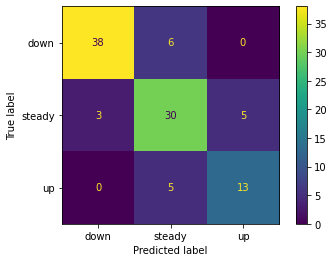

In [509]:
cm = confusion_matrix(res.actual,res.preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

<AxesSubplot:ylabel='features'>

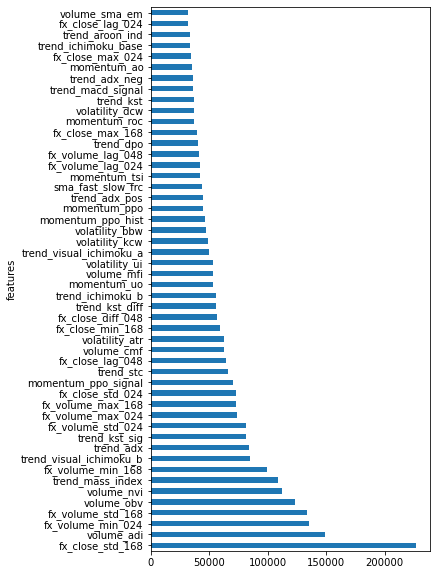

In [510]:
pd.concat(featimp_list)\
    .groupby(['features'])['importance'].sum()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='barh',figsize=(5,10))

### Evaluation scikit-plot

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


/Users/takis/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


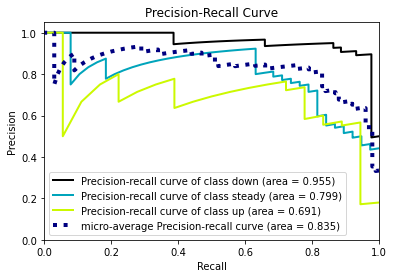

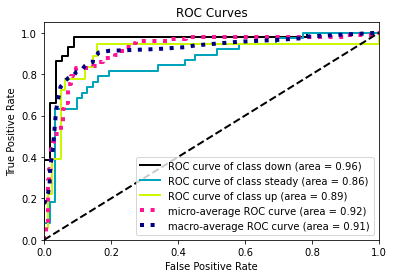

In [513]:
import scikitplot as skplt
print(skplt.metrics.plot_precision_recall_curve(res.actual, [x[0] for x in y_probs_list]))
print(skplt.metrics.plot_roc(res.actual, [x[0] for x in y_probs_list]))
# print(skplt.metrics.plot_calibration_curve(res.actual, [[x[0] for x in y_probs_list]]))

### Multiobjective Training Loop

In [65]:
%time
SPLITS = 100
tscv = TSCV(X,n_splits=SPLITS,test_size=1,max_train_size=5000,verbose=True)

clf_true = []
clf_preds_list = []
clf_probs_list = []
clf_featimp_list = []

rgr_true = []
rgr_preds_list = []
rgr_featimp_list = []

for foo in tqdm(tscv):
    
    # Train & Test Sets --------------------------------------
    train_idx,test_idx = foo
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y1_train, y1_test = md['target_bins_sign'].loc[train_idx], md['target_bins_sign'].loc[test_idx]
    y2_train, y2_test = md['target_rtrns'].loc[train_idx], md['target_rtrns'].loc[test_idx]
    
    # Classification Task ------------------------------------
    clf = LGBMClassifier(boosting_type='dart',n_estimators=500,objective='multiclass',n_jobs=-1)
    clf.fit(X_train,y1_train)
    clf_true.append(y1_test.iloc[0])
    clf_preds_list.append(clf.predict(X_test)[0])
    clf_probs_list.append(clf.predict_proba(X_test))
    clf_featimp_list.append(pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_}))
    
    # Regression Task ----------------------------------------
    rgr = LGBMRegressor(boosting_type='dart',n_estimators=500,n_jobs=-1)
    rgr.fit(X_train,y2_train)
    rgr_true.append(y2_test.iloc[0])
    rgr_preds_list.append(rgr.predict(X_test)[0])
    rgr_featimp_list.append(pd.DataFrame({'features':X_train.columns,'importance':rgr.feature_importances_}))
    
    print(100*'=')

0it [00:00, ?it/s]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
(01) train : 4500-9499 [5000] & test 9500-9500 [1]


1it [00:14, 14.24s/it]

(02) train : 4501-9500 [5000] & test 9501-9501 [1]


2it [00:28, 14.24s/it]

(03) train : 4502-9501 [5000] & test 9502-9502 [1]


3it [00:43, 14.65s/it]

(04) train : 4503-9502 [5000] & test 9503-9503 [1]


4it [00:57, 14.22s/it]

(05) train : 4504-9503 [5000] & test 9504-9504 [1]


5it [01:10, 14.07s/it]

(06) train : 4505-9504 [5000] & test 9505-9505 [1]


6it [01:24, 13.96s/it]

(07) train : 4506-9505 [5000] & test 9506-9506 [1]


7it [01:38, 13.85s/it]

(08) train : 4507-9506 [5000] & test 9507-9507 [1]


8it [01:51, 13.77s/it]

(09) train : 4508-9507 [5000] & test 9508-9508 [1]


9it [02:06, 13.97s/it]

(10) train : 4509-9508 [5000] & test 9509-9509 [1]


10it [02:20, 13.92s/it]

(11) train : 4510-9509 [5000] & test 9510-9510 [1]


11it [02:33, 13.86s/it]

(12) train : 4511-9510 [5000] & test 9511-9511 [1]


12it [02:47, 13.78s/it]

(13) train : 4512-9511 [5000] & test 9512-9512 [1]


13it [03:01, 13.74s/it]

(14) train : 4513-9512 [5000] & test 9513-9513 [1]


14it [03:16, 14.26s/it]

(15) train : 4514-9513 [5000] & test 9514-9514 [1]


15it [03:30, 14.07s/it]

(16) train : 4515-9514 [5000] & test 9515-9515 [1]


16it [03:43, 13.93s/it]

(17) train : 4516-9515 [5000] & test 9516-9516 [1]


17it [03:57, 13.85s/it]

(18) train : 4517-9516 [5000] & test 9517-9517 [1]


18it [04:11, 13.78s/it]

(19) train : 4518-9517 [5000] & test 9518-9518 [1]


19it [04:24, 13.78s/it]

(20) train : 4519-9518 [5000] & test 9519-9519 [1]


20it [04:38, 13.71s/it]

(21) train : 4520-9519 [5000] & test 9520-9520 [1]


21it [04:52, 13.68s/it]

(22) train : 4521-9520 [5000] & test 9521-9521 [1]


22it [05:06, 14.01s/it]

(23) train : 4522-9521 [5000] & test 9522-9522 [1]


23it [05:20, 13.91s/it]

(24) train : 4523-9522 [5000] & test 9523-9523 [1]


24it [05:34, 13.85s/it]

(25) train : 4524-9523 [5000] & test 9524-9524 [1]


25it [05:47, 13.78s/it]

(26) train : 4525-9524 [5000] & test 9525-9525 [1]


26it [06:01, 13.73s/it]

(27) train : 4526-9525 [5000] & test 9526-9526 [1]


27it [06:15, 13.81s/it]

(28) train : 4527-9526 [5000] & test 9527-9527 [1]


28it [06:29, 13.78s/it]

(29) train : 4528-9527 [5000] & test 9528-9528 [1]


29it [06:42, 13.80s/it]

(30) train : 4529-9528 [5000] & test 9529-9529 [1]


30it [06:56, 13.76s/it]

(31) train : 4530-9529 [5000] & test 9530-9530 [1]


31it [07:10, 13.70s/it]

(32) train : 4531-9530 [5000] & test 9531-9531 [1]


32it [07:23, 13.68s/it]

(33) train : 4532-9531 [5000] & test 9532-9532 [1]


33it [07:37, 13.63s/it]

(34) train : 4533-9532 [5000] & test 9533-9533 [1]


34it [07:50, 13.62s/it]

(35) train : 4534-9533 [5000] & test 9534-9534 [1]


35it [08:04, 13.61s/it]

(36) train : 4535-9534 [5000] & test 9535-9535 [1]


36it [08:18, 13.62s/it]

(37) train : 4536-9535 [5000] & test 9536-9536 [1]


37it [08:31, 13.61s/it]

(38) train : 4537-9536 [5000] & test 9537-9537 [1]


38it [08:45, 13.62s/it]

(39) train : 4538-9537 [5000] & test 9538-9538 [1]


39it [08:58, 13.60s/it]

(40) train : 4539-9538 [5000] & test 9539-9539 [1]


40it [09:12, 13.57s/it]

(41) train : 4540-9539 [5000] & test 9540-9540 [1]


41it [09:25, 13.55s/it]

(42) train : 4541-9540 [5000] & test 9541-9541 [1]


42it [09:39, 13.55s/it]

(43) train : 4542-9541 [5000] & test 9542-9542 [1]


43it [09:53, 13.54s/it]

(44) train : 4543-9542 [5000] & test 9543-9543 [1]


44it [10:06, 13.57s/it]

(45) train : 4544-9543 [5000] & test 9544-9544 [1]


45it [10:20, 13.64s/it]

(46) train : 4545-9544 [5000] & test 9545-9545 [1]


46it [10:35, 14.16s/it]

(47) train : 4546-9545 [5000] & test 9546-9546 [1]


47it [10:49, 14.00s/it]

(48) train : 4547-9546 [5000] & test 9547-9547 [1]


48it [11:02, 13.84s/it]

(49) train : 4548-9547 [5000] & test 9548-9548 [1]


49it [11:16, 13.80s/it]

(50) train : 4549-9548 [5000] & test 9549-9549 [1]


50it [11:30, 13.90s/it]

(51) train : 4550-9549 [5000] & test 9550-9550 [1]


51it [11:44, 13.82s/it]

(52) train : 4551-9550 [5000] & test 9551-9551 [1]


52it [11:58, 13.76s/it]

(53) train : 4552-9551 [5000] & test 9552-9552 [1]


53it [12:11, 13.69s/it]

(54) train : 4553-9552 [5000] & test 9553-9553 [1]


54it [12:25, 13.70s/it]

(55) train : 4554-9553 [5000] & test 9554-9554 [1]


55it [12:38, 13.67s/it]

(56) train : 4555-9554 [5000] & test 9555-9555 [1]


56it [12:52, 13.64s/it]

(57) train : 4556-9555 [5000] & test 9556-9556 [1]


57it [13:06, 13.61s/it]

(58) train : 4557-9556 [5000] & test 9557-9557 [1]


58it [13:19, 13.59s/it]

(59) train : 4558-9557 [5000] & test 9558-9558 [1]


59it [13:33, 13.56s/it]

(60) train : 4559-9558 [5000] & test 9559-9559 [1]


60it [13:46, 13.55s/it]

(61) train : 4560-9559 [5000] & test 9560-9560 [1]


61it [14:00, 13.56s/it]

(62) train : 4561-9560 [5000] & test 9561-9561 [1]


62it [14:13, 13.58s/it]

(63) train : 4562-9561 [5000] & test 9562-9562 [1]


63it [14:27, 13.59s/it]

(64) train : 4563-9562 [5000] & test 9563-9563 [1]


64it [14:41, 13.62s/it]

(65) train : 4564-9563 [5000] & test 9564-9564 [1]


65it [14:54, 13.61s/it]

(66) train : 4565-9564 [5000] & test 9565-9565 [1]


66it [15:08, 13.66s/it]

(67) train : 4566-9565 [5000] & test 9566-9566 [1]


67it [38:53, 437.03s/it]

(68) train : 4567-9566 [5000] & test 9567-9567 [1]


68it [39:09, 310.68s/it]

(69) train : 4568-9567 [5000] & test 9568-9568 [1]


69it [39:25, 222.44s/it]

(70) train : 4569-9568 [5000] & test 9569-9569 [1]


70it [39:42, 160.69s/it]

(71) train : 4570-9569 [5000] & test 9570-9570 [1]


71it [39:58, 117.37s/it]

(72) train : 4571-9570 [5000] & test 9571-9571 [1]


72it [40:12, 86.22s/it] 

(73) train : 4572-9571 [5000] & test 9572-9572 [1]


73it [40:25, 64.39s/it]

(74) train : 4573-9572 [5000] & test 9573-9573 [1]


74it [40:42, 50.24s/it]

(75) train : 4574-9573 [5000] & test 9574-9574 [1]


75it [40:58, 39.90s/it]

(76) train : 4575-9574 [5000] & test 9575-9575 [1]


76it [41:12, 32.23s/it]

(77) train : 4576-9575 [5000] & test 9576-9576 [1]


77it [41:28, 27.14s/it]

(78) train : 4577-9576 [5000] & test 9577-9577 [1]


78it [41:44, 23.75s/it]

(79) train : 4578-9577 [5000] & test 9578-9578 [1]


79it [41:58, 21.07s/it]

(80) train : 4579-9578 [5000] & test 9579-9579 [1]


80it [42:13, 19.22s/it]

(81) train : 4580-9579 [5000] & test 9580-9580 [1]


81it [42:28, 17.71s/it]

(82) train : 4581-9580 [5000] & test 9581-9581 [1]


82it [42:43, 17.12s/it]

(83) train : 4582-9581 [5000] & test 9582-9582 [1]


83it [42:57, 16.25s/it]

(84) train : 4583-9582 [5000] & test 9583-9583 [1]


84it [43:13, 16.17s/it]

(85) train : 4584-9583 [5000] & test 9584-9584 [1]


85it [43:29, 16.09s/it]

(86) train : 4585-9584 [5000] & test 9585-9585 [1]


86it [43:46, 16.18s/it]

(87) train : 4586-9585 [5000] & test 9586-9586 [1]


87it [44:03, 16.44s/it]

(88) train : 4587-9586 [5000] & test 9587-9587 [1]


88it [44:19, 16.23s/it]

(89) train : 4588-9587 [5000] & test 9588-9588 [1]


89it [44:34, 15.86s/it]

(90) train : 4589-9588 [5000] & test 9589-9589 [1]


90it [44:47, 15.23s/it]

(91) train : 4590-9589 [5000] & test 9590-9590 [1]


91it [45:01, 14.74s/it]

(92) train : 4591-9590 [5000] & test 9591-9591 [1]


92it [45:16, 14.84s/it]

(93) train : 4592-9591 [5000] & test 9592-9592 [1]


93it [45:30, 14.54s/it]

(94) train : 4593-9592 [5000] & test 9593-9593 [1]


94it [45:44, 14.33s/it]

(95) train : 4594-9593 [5000] & test 9594-9594 [1]


95it [45:57, 14.11s/it]

(96) train : 4595-9594 [5000] & test 9595-9595 [1]


96it [46:11, 13.96s/it]

(97) train : 4596-9595 [5000] & test 9596-9596 [1]


97it [46:25, 13.88s/it]

(98) train : 4597-9596 [5000] & test 9597-9597 [1]


98it [46:38, 13.78s/it]

(99) train : 4598-9597 [5000] & test 9598-9598 [1]


99it [46:52, 13.70s/it]

(100) train : 4599-9598 [5000] & test 9599-9599 [1]


100it [47:05, 28.26s/it]

In [566]:
# [x.shape for x in [X_train,y1_train,y2_train]]
# [x.shape for x in [X_test,y1_test,y2_test]]

In [66]:
res = pd.DataFrame({'clf_actual':clf_true,
                    'clf_preds':clf_preds_list,
                    'clf_probs_0':[x[0][0] for x in clf_probs_list],
                    'clf_probs_1':[x[0][1] for x in clf_probs_list],
                    'clf_probs_2':[x[0][2] for x in clf_probs_list],
                    'rgr_actual':rgr_true,
                    'rgr_preds':rgr_preds_list})
res

,clf_actual,clf_preds,clf_probs_0,clf_probs_1,clf_probs_2,rgr_actual,rgr_preds
0,steady,steady,0.206035,0.743151,0.050814,-0.011798,-0.018816
1,steady,steady,0.035965,0.950288,0.013747,-0.011798,-0.012732
2,steady,steady,0.032366,0.956308,0.011326,-0.007430,-0.013620
3,steady,steady,0.009363,0.978296,0.012341,-0.000313,-0.005095
4,steady,steady,0.013371,0.976911,0.009718,-0.015344,-0.000768
...,...,...,...,...,...,...,...
95,steady,steady,0.023151,0.722009,0.254840,0.017047,0.013029
96,steady,steady,0.073103,0.492989,0.433908,-0.017816,0.014540
97,steady,steady,0.020105,0.839966,0.139930,0.007060,-0.002276
98,steady,steady,0.036030,0.868201,0.095770,-0.003113,-0.000722


In [67]:
pd.crosstab(res.clf_actual,res.clf_preds)

clf_preds,down,steady,up
clf_actual,,,
down,38,6,0
steady,3,30,5
up,0,5,13


In [93]:
res.query("clf_actual!=clf_preds")[[x for x in res.columns if 'probs' not in x]].sort_values(by=['rgr_actual'])

,clf_actual,clf_preds,rgr_actual,rgr_preds
47,down,steady,-0.045357,-0.011122
67,down,steady,-0.041074,-0.018220
59,down,steady,-0.039986,-0.023311
46,down,steady,-0.038928,-0.002981
75,down,steady,-0.035049,-0.022140
66,down,steady,-0.033333,-0.019588
58,steady,down,-0.028627,-0.022900
94,steady,up,-0.013579,0.033933
93,steady,down,-0.011780,-0.018906
64,steady,down,-0.001933,-0.030460


In [74]:
accuracy_score(res.clf_actual,res.clf_preds)

0.81

In [78]:
print(classification_report(res.clf_actual,res.clf_preds))

              precision    recall  f1-score   support

        down       0.93      0.86      0.89        44
      steady       0.73      0.79      0.76        38
          up       0.72      0.72      0.72        18

    accuracy                           0.81       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.82      0.81      0.81       100



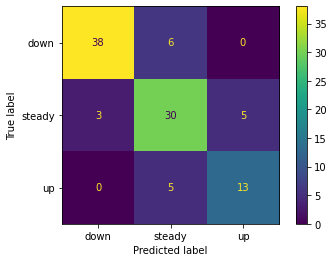

In [83]:
cm = confusion_matrix(res.clf_actual,res.clf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

<AxesSubplot:ylabel='features'>

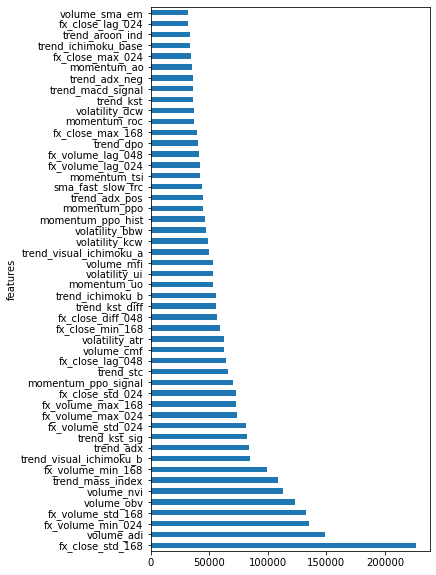

In [84]:
pd.concat(clf_featimp_list)\
    .groupby(['features'])['importance'].sum()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='barh',figsize=(5,10))

<AxesSubplot:xlabel='rgr_actual', ylabel='rgr_preds'>

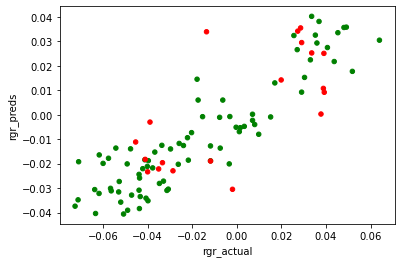

In [102]:
# res.assign(color = lambda x : x.clf_actual.map({
#     'steady':'black','down':'red','up':'blue'
# })).plot.scatter(x='rgr_actual',y='rgr_preds',c='color')

res.assign(color = lambda x : np.where(x.clf_actual==x.clf_preds,'green','red')).\
    plot.scatter(x='rgr_actual',y='rgr_preds',c='color')

In [88]:
print(f'mean_absolute_error : {mean_absolute_error(res.rgr_actual,res.rgr_preds)}')
print(f'mean_absolute_percentage_error : {mean_absolute_percentage_error(res.rgr_actual,res.rgr_preds):}')
print(f'mean_squared_error : {mean_squared_error(res.rgr_actual,res.rgr_preds)}')
print(f'median_absolute_error : {median_absolute_error(res.rgr_actual,res.rgr_preds)}')
print(f'r2_score : {r2_score(res.rgr_actual,res.rgr_preds)}')

mean_absolute_error : 0.01683804334827456
mean_absolute_percentage_error : 1.006678943829433
mean_squared_error : 0.000426908930026047
median_absolute_error : 0.013849865371937246
r2_score : 0.6658851459064999


<AxesSubplot:ylabel='features'>

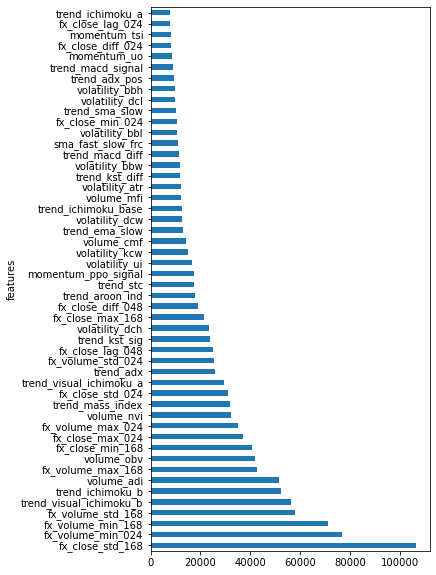

In [89]:
pd.concat(rgr_featimp_list)\
    .groupby(['features'])['importance'].sum()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='barh',figsize=(5,10))